In [1]:
import numpy as np
import pandas as pd
import glob
import os
import sys
PROJECT_REPO_DIR = os.path.abspath('../../MIMIC-IV/PC-HMM')
sys.path.append(PROJECT_REPO_DIR)
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'pcvae'))

from pcvae.datasets.toy import toy_line, custom_dataset, custom_regression_dataset
from pcvae.models.hmm import HMM
from pcvae.datasets.base import dataset, real_dataset, classification_dataset, make_dataset

import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score)

import seaborn as sns
# sys.path.append(os.path.abspath('../PC-HMM/'))
# from main_mimic_semi_supervised_ordinal import compute_binary_classification_perf
%matplotlib inline

In [2]:
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/eicu_v2.0/mortality_prediction/'

## Get performance of PC-HMM classification as a function of % labelled sequences

In [3]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']


pchmm_perf_dict_list = []
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/mortality_prediction/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    print('best_model : %s'%best_model_weights)
    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_dataset(data_dict=data_dict)

    n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])
    # load the best PCHMM model
    model = HMM(states=n_states,
                observation_dist='NormalWithMissing',
                predictor_dist='Categorical')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)
    y_test_pred_proba = model._predictor.predict(z_test)
    labelled_inds_te = ~np.isnan(y_test[:,0])
    test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
    test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])

    pchmm_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC : %.3f'%test_auprc)
    print('test AUROC : %.3f'%test_roc_auc)
    print('=====================================================================================')

pchmm_perf_df = pd.DataFrame(pchmm_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=412-init_strategy=kmeans-batch_size=128-perc_labelled=1.2-predictor_l2_penalty=0-n_states=5-lamb=100-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 1.2 perc labelled sequences=========
test AUPRC : 0.139
test AUROC : 0.685
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.001-seed=5325-init_strategy=kmeans-batch_size=128-perc_labelled=3.7-predictor_l2_penalty=0-n_states=20-lamb=500-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 3.7 perc labelled sequences=========
test AUPRC : 0.152
test AUROC : 0.668
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=123819-init_strategy=kmeans-batch_size=128-perc_labelled=11.1-predictor_l2_penalty=0-n_states=5-lamb=100-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 11.1 perc labelled sequences=========
test AUPRC : 0.190
test AUROC : 0.724
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=891-init_strategy=kmeans-batch_size=256-perc_labelled=33.3-predictor_l2_penalty=0-n_states=5-lamb=100-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 33.3 perc labelled sequences=========
test AUPRC : 0.207
test AUROC : 0.742
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=8412-init_strategy=kmeans-batch_size=128-perc_labelled=100-predictor_l2_penalty=0-n_states=5-lamb=50-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 100 perc labelled sequences=========
test AUPRC : 0.242
test AUROC : 0.790


## Get performance of HMM + predictor trained separately

In [4]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']


hmm_plus_pred_perf_dict_list = []
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/mortality_prediction/final_perf*perc_labelled=%s-*lamb=0*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    print('best_model : %s'%best_model_weights)
    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_dataset(data_dict=data_dict)

    n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])
    # load the best PCHMM model
    model = HMM(states=n_states,
                observation_dist='NormalWithMissing',
                predictor_dist='Categorical')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)
    y_test_pred_proba = model._predictor.predict(z_test)
    labelled_inds_te = ~np.isnan(y_test[:,0])
    test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
    test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])

    hmm_plus_pred_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC : %.3f'%test_auprc)
    print('test AUROC : %.3f'%test_roc_auc)
    print('=====================================================================================')

hmm_plus_pred_perf_df = pd.DataFrame(hmm_plus_pred_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=2577-init_strategy=kmeans-batch_size=256-perc_labelled=1.2-predictor_l2_penalty=0-n_states=5-lamb=0-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 1.2 perc labelled sequences=========
test AUPRC : 0.129
test AUROC : 0.718
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.001-seed=12-init_strategy=kmeans-batch_size=256-perc_labelled=3.7-predictor_l2_penalty=0.1-n_states=5-lamb=0-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 3.7 perc labelled sequences=========
test AUPRC : 0.129
test AUROC : 0.705
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.001-seed=12-init_strategy=kmeans-batch_size=256-perc_labelled=11.1-predictor_l2_penalty=0-n_states=5-lamb=0-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 11.1 perc labelled sequences=========
test AUPRC : 0.128
test AUROC : 0.702
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.001-seed=12-init_strategy=kmeans-batch_size=128-perc_labelled=33.3-predictor_l2_penalty=0-n_states=5-lamb=0-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 33.3 perc labelled sequences=========
test AUPRC : 0.124
test AUROC : 0.682
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.001-seed=5325-init_strategy=kmeans-batch_size=256-perc_labelled=100-predictor_l2_penalty=0.1-n_states=5-lamb=0-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 100 perc labelled sequences=========
test AUPRC : 0.126
test AUROC : 0.692


## Get performance of HMM + predictor trained with max likelihood (lambda=1)

In [5]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']


supervised_pchmm_perf_dict_list = []
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/mortality_prediction/final_perf*perc_labelled=%s-*lamb=1.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    print('best_model : %s'%best_model_weights)
    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_dataset(data_dict=data_dict)

    n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])
    # load the best PCHMM model
    model = HMM(states=n_states,
                observation_dist='NormalWithMissing',
                predictor_dist='Categorical')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)
    y_test_pred_proba = model._predictor.predict(z_test)
    labelled_inds_te = ~np.isnan(y_test[:,0])
    test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
    test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])

    supervised_pchmm_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC : %.3f'%test_auprc)
    print('test AUROC : %.3f'%test_roc_auc)
    print('=====================================================================================')

supervised_pchmm_pred_perf_df = pd.DataFrame(supervised_pchmm_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=5325-init_strategy=kmeans-batch_size=128-perc_labelled=1.2-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 1.2 perc labelled sequences=========
test AUPRC : 0.131
test AUROC : 0.696
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.001-seed=12-init_strategy=kmeans-batch_size=128-perc_labelled=3.7-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 3.7 perc labelled sequences=========
test AUPRC : 0.131
test AUROC : 0.698
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.001-seed=2577-init_strategy=kmeans-batch_size=128-perc_labelled=11.1-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 11.1 perc labelled sequences=========
test AUPRC : 0.136
test AUROC : 0.701
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=5325-init_strategy=kmeans-batch_size=256-perc_labelled=33.3-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 33.3 perc labelled sequences=========
test AUPRC : 0.172
test AUROC : 0.680
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction/semi-supervised-pchmm-lr=0.005-seed=12-init_strategy=kmeans-batch_size=256-perc_labelled=100-predictor_l2_penalty=0-n_states=5-lamb=1-weights.h5
Class dist 0.05465631442733693
Training data shape: (22797, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================mortality classification with 100 perc labelled sequences=========
test AUPRC : 0.205
test AUROC : 0.728


## Get performance of GRU-D classification as a function of % labelled sequences

In [6]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
grud_perf_dict_list = []

for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/GRUD/mortality_prediction/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]

    test_roc_auc = perf_df['test_AUC']
    test_auprc = perf_df['test_AUPRC']


    grud_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC : %.3f'%test_auprc)
    print('test AUROC : %.3f'%test_roc_auc)
    print('=====================================================================================')

grud_perf_df = pd.DataFrame(grud_perf_dict_list)

================mortality classification with 1.2 perc labelled sequences=========
test AUPRC : 0.138
test AUROC : 0.710
================mortality classification with 3.7 perc labelled sequences=========
test AUPRC : 0.170
test AUROC : 0.737
================mortality classification with 11.1 perc labelled sequences=========
test AUPRC : 0.184
test AUROC : 0.751
================mortality classification with 33.3 perc labelled sequences=========
test AUPRC : 0.204
test AUROC : 0.763
================mortality classification with 100 perc labelled sequences=========
test AUPRC : 0.213
test AUROC : 0.778


## Get the MixMatch Performance as a function of % labelled sequences

In [7]:
mixmatch_perf_dict_list = []
    
for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/MixMatch/mortality_prediction/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    try:
        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]

        test_roc_auc = perf_df['test_AUROC'].values[-1]
        test_auprc = perf_df['test_AUPRC'].values[-1]
    except:
        test_roc_auc=np.nan
        test_auprc=np.nan


    mixmatch_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC : %.3f'%test_auprc)
    print('test AUROC : %.3f'%test_roc_auc)
    print('=====================================================================================')

mixmatch_perf_df = pd.DataFrame(mixmatch_perf_dict_list)

================mortality classification with 1.2 perc labelled sequences=========
test AUPRC : 0.078
test AUROC : 0.602
================mortality classification with 3.7 perc labelled sequences=========
test AUPRC : 0.106
test AUROC : 0.622
================mortality classification with 11.1 perc labelled sequences=========
test AUPRC : 0.119
test AUROC : 0.630
================mortality classification with 33.3 perc labelled sequences=========
test AUPRC : 0.133
test AUROC : 0.671
================mortality classification with 100 perc labelled sequences=========
test AUPRC : 0.125
test AUROC : 0.655


## Get FixMatch performance as a function of % labelled sequences

In [30]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
fixmatch_perf_dict_list = []

for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/FixMatch/mortality_prediction/final_perf*lr=0.00*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]
    
    
    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    print(perf_csvs[best_ind])
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]

    test_roc_auc = perf_df['test_AUROC'].values[-1]
    test_auprc = perf_df['test_AUPRC'].values[-1]


    fixmatch_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC : %.3f'%test_auprc)
    print('test AUROC : %.3f'%test_roc_auc)
    print('=====================================================================================')

fixmatch_perf_df = pd.DataFrame(fixmatch_perf_dict_list)

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/FixMatch/mortality_prediction/final_perf_FixMatch-lr=0.001-seed=613-batch_size=128-perc_labelled=1.2.csv
================mortality classification with 1.2 perc labelled sequences=========
test AUPRC : 0.101
test AUROC : 0.622
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/FixMatch/mortality_prediction/final_perf_FixMatch-lr=0.005-seed=1092-batch_size=256-perc_labelled=3.7.csv
================mortality classification with 3.7 perc labelled sequences=========
test AUPRC : 0.109
test AUROC : 0.646
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/FixMatch/mortality_prediction/final_perf_FixMatch-lr=0.001-seed=6504-batch_size=512-perc_labelled=11.1.csv
================mortality classification with 11.1 perc labelled sequences=========
test AUPRC : 0.131
test AUROC : 0.683
/cluster/tufts/hugheslab/prath01/projects/pchmm-mis

In [29]:
!rm /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/FixMatch/mortality_prediction/*FixMatch-lr=0.005-seed=231-batch_size=128-perc_labelled=100*

## Get BRITS performance as a function of % labelled sequences

In [24]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
brits_perf_dict_list = []

for perc_labelled in perc_labelled_list:

    perf_csvs = glob.glob(os.path.abspath('../results/BRITS/mortality_prediction/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['AUPRC_valid'].values[-1]
        test_auprc_np[ii] = curr_perf_df['AUPRC_test'].values[-1]

    # curr_perf_df
    try:
        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]
        print(perf_csvs[best_ind])
        test_roc_auc = perf_df['AUC_test'].values[-1]
        test_auprc = perf_df['AUPRC_test'].values[-1]
    except:
        test_roc_auc=np.nan
        test_auprc=np.nan


    brits_perf_dict_list.append({'perc_labelled' : perc_labelled,
                     'test_AUC' : test_roc_auc,
                     'test_AUPRC' : test_auprc})



    print('================mortality classification with %s perc labelled sequences========='%(perc_labelled))
    print('test AUPRC : %.3f'%test_auprc)
    print('test AUROC : %.3f'%test_roc_auc)
    print('=====================================================================================')

brits_perf_df = pd.DataFrame(brits_perf_dict_list)

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/BRITS/mortality_prediction/final_perf_BRITS-lr=0.001-seed=6504-batch_size=256-perc_labelled=1.2.csv
================mortality classification with 1.2 perc labelled sequences=========
test AUPRC : 0.109
test AUROC : 0.634
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/BRITS/mortality_prediction/final_perf_BRITS-lr=0.001-seed=6504-batch_size=128-perc_labelled=3.7.csv
================mortality classification with 3.7 perc labelled sequences=========
test AUPRC : 0.095
test AUROC : 0.633
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/BRITS/mortality_prediction/final_perf_BRITS-lr=0.001-seed=2414-batch_size=128-perc_labelled=11.1.csv
================mortality classification with 11.1 perc labelled sequences=========
test AUPRC : 0.139
test AUROC : 0.677
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited

## Plot binary classification SSL performance 

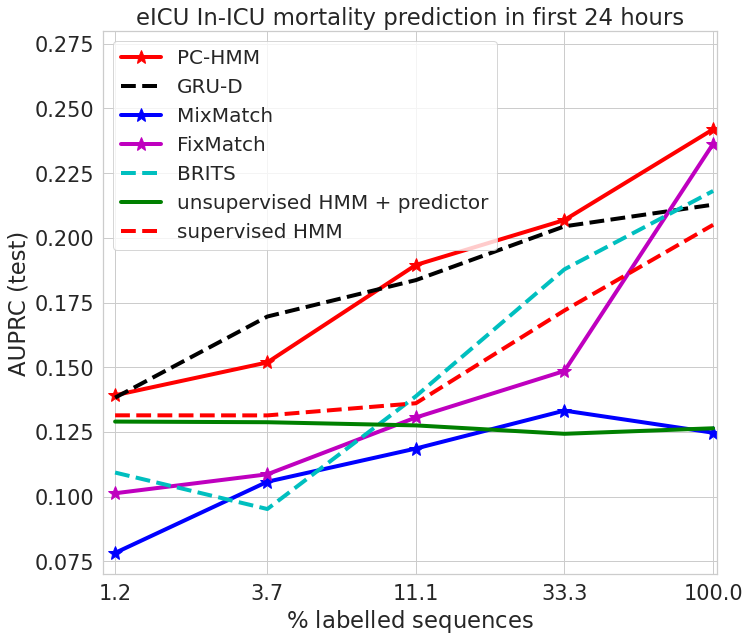

In [31]:
pchmm_perf_df['perc_labelled'] = pchmm_perf_df['perc_labelled'].astype(float)
grud_perf_df['perc_labelled'] = grud_perf_df['perc_labelled'].astype(float)
mixmatch_perf_df['perc_labelled'] = mixmatch_perf_df['perc_labelled'].astype(float)
fixmatch_perf_df['perc_labelled'] = fixmatch_perf_df['perc_labelled'].astype(float)
brits_perf_df['perc_labelled'] = brits_perf_df['perc_labelled'].astype(float)
hmm_plus_pred_perf_df['perc_labelled'] = hmm_plus_pred_perf_df['perc_labelled'].astype(float)
supervised_pchmm_pred_perf_df['perc_labelled'] = supervised_pchmm_pred_perf_df['perc_labelled'].astype(float)


ylims_list = [None,
             None,
             [0.08, 0.3]] 

f, axs = plt.subplots(1, 1, figsize=(11, 10))
sns.set_context('notebook', font_scale=1.9)
sns.set_style('whitegrid')
curr_pchmm_perf_df = pchmm_perf_df.sort_values(by='perc_labelled')
curr_grud_perf_df = grud_perf_df.sort_values(by='perc_labelled')
curr_mixmatch_perf_df = mixmatch_perf_df.sort_values(by='perc_labelled')
curr_fixmatch_perf_df = fixmatch_perf_df.sort_values(by='perc_labelled')
curr_brits_perf_df = brits_perf_df.sort_values(by='perc_labelled')
curr_hmm_plus_pred_perf_df = hmm_plus_pred_perf_df.sort_values(by='perc_labelled')
curr_supervised_hmm_pred_perf_df = supervised_pchmm_pred_perf_df.sort_values(by='perc_labelled')



perc_labelled = curr_pchmm_perf_df['perc_labelled'].values
test_auprc_pchmm_np = curr_pchmm_perf_df['test_AUPRC'].values
test_auprc_grud = curr_grud_perf_df['test_AUPRC'].values
test_auprc_mixmatch = curr_mixmatch_perf_df['test_AUPRC'].values
test_auprc_fixmatch = curr_fixmatch_perf_df['test_AUPRC'].values
test_auprc_brits = curr_brits_perf_df['test_AUPRC'].values
test_auprc_hmm_plus_pred = curr_hmm_plus_pred_perf_df['test_AUPRC'].values
test_auprc_supervised_hmm = curr_supervised_hmm_pred_perf_df['test_AUPRC'].values

lw=4
axs.plot(perc_labelled, test_auprc_pchmm_np, 'r*-', markersize=15, linewidth=lw, label='PC-HMM')
axs.plot(perc_labelled, test_auprc_grud, 'k--', linewidth=lw, label='GRU-D')
axs.plot(perc_labelled, test_auprc_mixmatch, 'b*-', linewidth=lw, markersize=15, label='MixMatch')
axs.plot(perc_labelled, test_auprc_fixmatch, 'm*-', linewidth=lw, markersize=15, label='FixMatch')
axs.plot(perc_labelled, test_auprc_brits, 'c--', linewidth=lw, label='BRITS')
axs.plot(perc_labelled, test_auprc_hmm_plus_pred, 'g-', linewidth=lw, label='unsupervised HMM + predictor')
axs.plot(perc_labelled, test_auprc_supervised_hmm, 'r--', linewidth=lw, label='supervised HMM')

#     axs.legend(bbox_to_anchor=(0.99, 1.05))
axs.set_title('eICU In-ICU mortality prediction in first 24 hours')

axs.set_xscale('log')    
axs.set_xticks(perc_labelled)
axs.set_xticklabels(perc_labelled)

axs.set_xlim([1.1, 103])
axs.set_ylim([0.07, 0.28])

# if ylims_list[pp] is not None:
#     axs.set_ylim(ylims_list[pp])
axs.set_ylabel('AUPRC (test)')
axs.set_xlabel(r'$\%$ labelled sequences')

axs.legend(
#             bbox_to_anchor=(0.99, 1.05),
loc='upper left', fontsize=20
)
    
f.savefig('perf_mortality_prediction_eicu.pdf',
          bbox_inches='tight')
f.savefig('perf_mortality_prediction_eicu.png',
          bbox_inches='tight')

    

In [40]:
legend.legendHandles

## Compare performance of various PC-HMM ordinal regression models across different number of states

In [17]:
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_prediction_ordinal'
# f, axs = plt.subplots(1, 1, figsize=(12, 8))

states_list = ['5', '10', '20', '40']
# perc_labelled_list = ['1.2', '3.7', '11.1', '33.3']
train_auprc_per_state_np = np.zeros(len(states_list))
val_auprc_per_state_np = np.zeros(len(states_list))
test_auprc_per_state_np = np.zeros(len(states_list))
# for perc_labelled in perc_labelled_list:
for jj, n_states in enumerate(states_list):
    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*n_states=%s*.csv'%(n_states)))

    # perf_csvs = [ii for ii in perf_csvs if 'perc_labelled' not in ii]

    train_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_3 = np.zeros(len(perf_csvs))
    test_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_7 = np.zeros(len(perf_csvs))
    test_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_11 = np.zeros(len(perf_csvs))
    test_auprc_np_11 = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        train_auprc_np_3[ii] = curr_perf_df['train_AUPRC_3'].values[-1]
        valid_auprc_np_3[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
        test_auprc_np_3[ii] = curr_perf_df['test_AUPRC_3'].values[-1]

        valid_auprc_np_7[ii] = curr_perf_df['valid_AUPRC_7'].values[-1]
        test_auprc_np_7[ii] = curr_perf_df['test_AUPRC_7'].values[-1]

        valid_auprc_np_11[ii] = curr_perf_df['valid_AUPRC_11'].values[-1]
        test_auprc_np_11[ii] = curr_perf_df['test_AUPRC_11'].values[-1]


    best_ind_tr = np.argmax(train_auprc_np_3)
    best_ind_va = np.argmax(valid_auprc_np_3)
    perf_df = pd.read_csv(perf_csvs[best_ind_tr])


    train_auprc_per_state_np[jj] = train_auprc_np_3[best_ind_tr]
    val_auprc_per_state_np[jj] = valid_auprc_np_3[best_ind_va]
    test_auprc_per_state_np[jj] = test_auprc_np_3[best_ind_va]
    print('Train AUPRC for n_states = %s : %.3f'%(n_states, train_auprc_np_3[best_ind_tr]))
    print('Val AUPRC for n_states = %s : %.3f'%(n_states, valid_auprc_np_3[best_ind_va]))
    print('Test AUPRC for n_states = %s : %.3f'%(n_states, test_auprc_np_3[best_ind_va]))
    best_model_perf_csv = perf_csvs[best_ind_va]
    print(best_model_perf_csv)

Train AUPRC for n_states = 5 : 0.847
Val AUPRC for n_states = 5 : 0.683
Test AUPRC for n_states = 5 : 0.703
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.01-seed=152-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0-n_states=5-lamb=100.csv
Train AUPRC for n_states = 10 : 0.891
Val AUPRC for n_states = 10 : 0.681
Test AUPRC for n_states = 10 : 0.701
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.01-seed=124-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0-n_states=10-lamb=50.csv
Train AUPRC for n_states = 20 : 0.960
Val AUPRC for n_states = 20 : 0.679
Test AUPRC for n_states = 20 : 0.694
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.

Text(0.5, 1.0, 'Prediction of LOS > 3 with ordinal model')

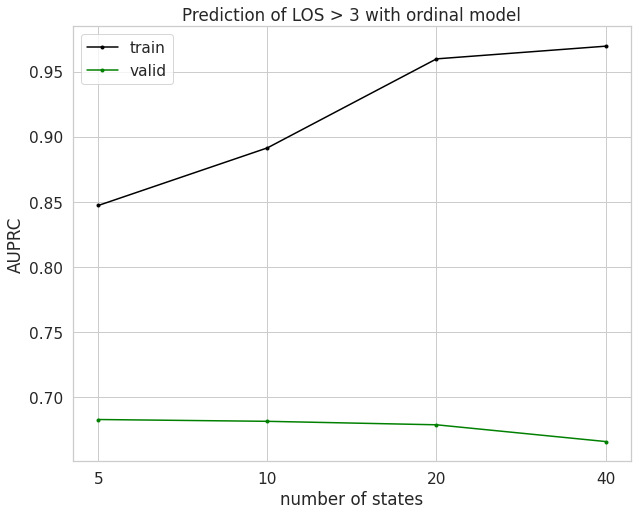

In [18]:
f, axs = plt.subplots(1, 1, figsize=(10, 8))
sns.set_context('notebook', font_scale=1.4)
sns.set_style('whitegrid')
axs.plot(np.array(states_list), train_auprc_per_state_np, 'k.-', label='train')
axs.plot(np.array(states_list), val_auprc_per_state_np, 'g.-', label='valid')
# axs.plot(np.array(states_list), test_auprc_per_state_np, 'b.-', label='test')
axs.legend()
axs.set_ylabel('AUPRC')
axs.set_xlabel('number of states')
axs.set_title('Prediction of LOS > 3 with ordinal model')

## plot the performance as a function of penalty

In [19]:
# penalty_list = ['0', '1e-07', '1e-05', '0.001', '0.1', '0.25', '0.5', '1', '5', '10']
penalty_list = ['0', '1e-07', '1e-05', '0.001', '0.005', '0.1', '0.25', '0.5', '1', '5', '10']
test_perf_per_penalty = []
val_perf_per_penalty = []
train_perf_per_penalty = []
for pen in penalty_list:
    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*predictor_l2_penalty=%s-*n_states=20*.csv'%pen))
    
    train_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_3 = np.zeros(len(perf_csvs))
    test_auprc_np_3 = np.zeros(len(perf_csvs))
    
    train_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_7 = np.zeros(len(perf_csvs))
    test_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_11 = np.zeros(len(perf_csvs))
    test_auprc_np_11 = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        train_auprc_np_3[ii] = curr_perf_df['train_AUPRC_3'].values[-1]
        valid_auprc_np_3[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
        test_auprc_np_3[ii] = curr_perf_df['test_AUPRC_3'].values[-1]
        
        train_auprc_np_7[ii] = curr_perf_df['train_AUPRC_7'].values[-1]
        valid_auprc_np_7[ii] = curr_perf_df['valid_AUPRC_7'].values[-1]
        test_auprc_np_7[ii] = curr_perf_df['test_AUPRC_7'].values[-1]

        valid_auprc_np_11[ii] = curr_perf_df['valid_AUPRC_11'].values[-1]
        test_auprc_np_11[ii] = curr_perf_df['test_AUPRC_11'].values[-1]


    best_ind = np.argmax(valid_auprc_np_3)
    val_perf_per_penalty.append(valid_auprc_np_3[best_ind])
    test_perf_per_penalty.append(test_auprc_np_3[best_ind])
    train_perf_per_penalty.append(train_auprc_np_3[best_ind])

Text(0.5, 1.0, 'Prediction of LOS > 3 with 20 state PC-HMM ordinal model')

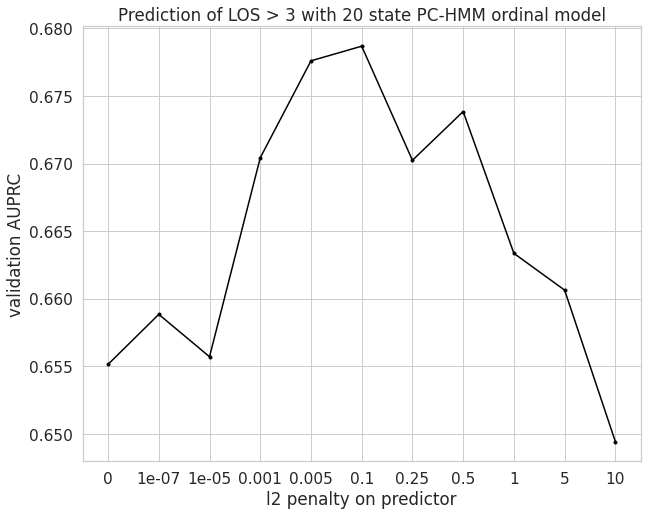

In [20]:
f, axs = plt.subplots(1, 1, figsize=(10, 8))
sns.set_context('notebook', font_scale=1.4)
sns.set_style('whitegrid')
axs.plot(np.array(penalty_list), np.array(val_perf_per_penalty), 'k.-')
axs.set_ylabel('validation AUPRC')
axs.set_xlabel('l2 penalty on predictor')
axs.set_title('Prediction of LOS > 3 with 20 state PC-HMM ordinal model')

In [45]:
test_perf_per_penalty

[0.5434338285561435, 0.5613730226929461]

## Plot the loss plots for the 20 state PC-HMM

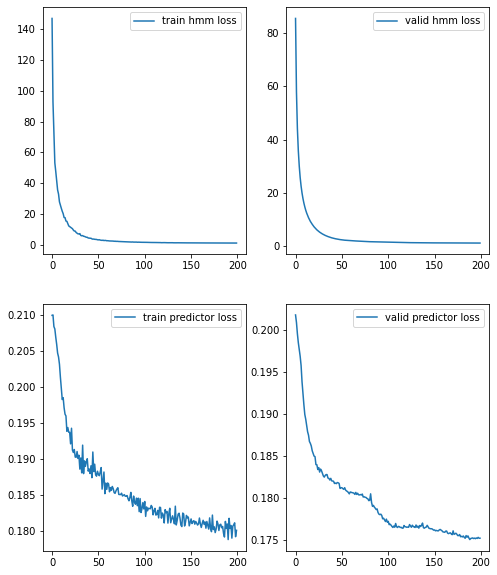

In [5]:


save_dir = "/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/mortality_prediction"
hist_csv = os.path.join(save_dir, "semi-supervised-pchmm-lr=0.005-seed=120-init_strategy=kmeans-batch_size=256-perc_labelled=100-predictor_l2_penalty=0-n_states=5-lamb=100.csv")

f, axs = plt.subplots(2, 2, figsize=(8, 10))
axs_list = axs.flatten()
lamb = int(hist_csv.replace('.csv', '').split('lamb=')[-1])

final_hist_df = pd.read_csv(hist_csv)

epochs = range(len(final_hist_df))
train_hmm_loss = final_hist_df['hmm_model_loss'].values
val_hmm_loss = final_hist_df['val_hmm_model_loss'].values

train_predictor_loss = final_hist_df['predictor_loss'].values/lamb
val_predictor_loss = final_hist_df['val_predictor_loss'].values/lamb

axs_list[0].plot(epochs, train_hmm_loss, label='train hmm loss')
axs_list[1].plot(epochs, val_hmm_loss, label='valid hmm loss')

axs_list[2].plot(epochs, train_predictor_loss, label='train predictor loss')
axs_list[3].plot(epochs, val_predictor_loss, label='valid predictor loss')

for ax in axs_list:
    ax.legend()

In [6]:
446*3

1338